In [116]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy.stats as stats
import copy

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\elmog\AppData\Local\Temp\ipykernel_34300\1847374139.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [117]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [118]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 

# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets

In [119]:
print(f'features keys:\n{X.keys()}')

features keys:
Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age'],
      dtype='object')


In [120]:
# concatenate X & Y into 1 dataframe
data = pd.concat([X, y], axis=1)
print(data)

      Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0      540.0                 0.0      0.0  162.0               2.5   
1      540.0                 0.0      0.0  162.0               2.5   
2      332.5               142.5      0.0  228.0               0.0   
3      332.5               142.5      0.0  228.0               0.0   
4      198.6               132.4      0.0  192.0               0.0   
...      ...                 ...      ...    ...               ...   
1025   276.4               116.0     90.3  179.6               8.9   
1026   322.2                 0.0    115.6  196.0              10.4   
1027   148.5               139.4    108.6  192.7               6.1   
1028   159.1               186.7      0.0  175.6              11.3   
1029   260.9               100.5     78.3  200.6               8.6   

      Coarse Aggregate  Fine Aggregate  Age  Concrete compressive strength  
0               1040.0           676.0   28                          79.99  
1    

In [121]:
# Step 0: Normalize z-score the data
data = ( data - data.mean() ) / data.std(ddof=1)

In [122]:
dataOrig = copy.deepcopy( data )

In [123]:
### Replace some elements with NAN - method # 1
number2NAN = 10
values2NAN = np.random.choice(len(data), size=number2NAN)
# data['Superplasticizer'][values2NAN] = np.nan
data.loc[values2NAN, 'Superplasticizer'] = np.nan
rowsWithValidData = np.where(~data['Superplasticizer'].isna())[0]

In [124]:
### Replace some elements with NAN - method # 2
# if 'Superplasticizer' in data.columns:
#     # Select 10 random indices from X
#     random_indices = data.sample(n=10, random_state=42).index
#     print(random_indices)
#     data.loc[random_indices, 'Superplasticizer'] = np.nan
#     print(data.loc[random_indices])
# else:
#     print("The 'Superplasticizer' column does not exist in the DataFrame.")

In [125]:
# Step 1: Convert from pandas data to tensor
# Step 2: Split the data into Train & Test

# Superplasticizer column dropped for TRAIN Dataset
cols2keep = data.keys()
cols2keep = cols2keep.drop('Superplasticizer')

#dataframe TRAIN -> train tensor + split data to train data & train labels
train_dataT = torch.tensor( data[cols2keep].values ).float()
train_dataT = train_dataT[ rowsWithValidData, : ]

train_labelsT = torch.tensor( data['Superplasticizer'].values ).float()
train_labelsT = train_labelsT[ rowsWithValidData, None ]

#dataframe TEST -> Test tensor + split data to train data & train labels
test_dataT = torch.tensor( data[cols2keep].values ).float()
test_dataT = test_dataT[ values2NAN, : ]

test_labelsT = torch.tensor( data['Superplasticizer'].values ).float()
test_labelsT = test_labelsT[ values2NAN, None ]

In [126]:
# confirm sizes
print(f'original data: {data.shape}')
print(f'Train data   : {train_dataT.shape}')
print(f'Train label  : {train_labelsT.shape}')
print(f'Test  data   : {test_dataT.shape}')
print(f'Test label   : {test_labelsT.shape}')

original data: (1030, 9)
Train data   : torch.Size([1020, 8])
Train label  : torch.Size([1020, 1])
Test  data   : torch.Size([10, 8])
Test label   : torch.Size([10, 1])


In [127]:
# Step 3: Convert into PyTorch Datasets
train_data = TensorDataset(train_dataT, train_labelsT)
test_data  = TensorDataset(test_dataT , test_labelsT)

In [128]:
print(f'train data shape: {train_data.tensors[0].shape}')
print(f'test data shape: {test_data.tensors[0].shape}')

train data shape: torch.Size([1020, 8])
test data shape: torch.Size([10, 8])


In [129]:
# Step 4: Translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
# test_loader  = DataLoader(test_data,  batch_size=test_data.tensors[0].shape[0])

In [130]:
# check sizes of data batches
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])
torch.Size([16, 8]) torch.Size([16, 1])


In [131]:
# Create the Deep Learning Model
def createTheNet():
    class nnClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(8,64)
            
            # self.bnormHidden1 =  nn.BatchNorm1d(39)
            self.hidden1 = nn.Linear(64,64)
            
            # self.bnormHidden2 =  nn.BatchNorm1d(64)
            self.hidden2 = nn.Linear(64,10)
            
            self.output = nn.Linear(10,1)
            
        def forward(self, x):
            
            x = F.relu( self.input(x) )
            
            # x = self.bnormHidden1(x)
            x = F.relu( self.hidden1(x) )

            # x = self.bnormHidden2(x)
            x = F.relu( self.hidden2(x) )
            
            x = self.output(x)
            
            return x
        
    modelInstance = nnClassNet().to(device)
    
    lossfun = nn.MSELoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.01)#, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer

In [132]:
# test the model that is has NO ERRORS!

net2, lossfun, optimizer = createTheNet()

input = torch.rand(39,8).to(device)
net2.eval()
net2(input)
net2.train()

nnClassNet(
  (input): Linear(in_features=8, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [133]:
# Train the Model

def trainTheModel(trainedModel, lossfun, optimizer, epochs=100):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []
    
    for epochi in range(numepochs):
        
        #batch loss & accuracy
        batchLoss = []
        batchAcc  = []
        
        #loop over mini-batches
        for X,y in train_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)
            
            #Forward pass & loss
            yHat = trainedModel(X)
            loss = lossfun(yHat, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            batchLoss.append(loss.item())
            
            # accuracy from this batch for categorical data
            # batchMathces = (torch.abs(yHat - y)).detach().cpu().float().numpy()
            # batchAcc.append(( batchMathces < 1))
            
            #accuracy from this batch -> for BCE sigmoid
            # accMatches = torch.sigmoid(yHat) > 0.5 ##
            # accMatchesNumeric = accMatches.float()
            # batchAcc.append( torch.mean( (accMatchesNumeric == y).float() ).item() )
        
        #average accuracy across mini-batches
        # trainAcc.append(100 * np.mean((batchAcc)))
        
        #average losses across all mini-batches
        losses[epochi] = np.mean(batchLoss)
        
        ################################
        # eval mode
        # do not use dropout 
        # do not use batch normalization instead use avg
        # trainedModel.eval()
        #final forward pass for Test Accuracy
        # X,y = next(iter(test_loader))
        
        # push data to GPU
        # X = X.to(device)
        # y = y.to(device)

        # with torch.no_grad():
            # yHat = trainedModel(X)
            
        #compute the test accuracy for categorical data
        # testMatches = (torch.abs(yHat - y)).detach().cpu().float().numpy()
        # testMatchesNumeric = (testMatches < 1)
        # testAcc.append(100 * np.mean( testMatchesNumeric ) )

        #compute the test accuracy for BCE sigmoid
        # testMatches = torch.sigmoid(yHat) > 0.5 
        # testMatchesNumeric = testMatches.float()
        # testAcc.append(100 * torch.mean( (testMatchesNumeric == y).float() ).item() )
    
    return losses, trainedModel
    # return trainAcc, testAcc, losses, trainedModel

In [134]:
# Test the training code that it has NO ERRORS
epochs=1
myModelInstance2, lossfun, optimizer = createTheNet()
losses, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
# trainAcc, testAcc, losses, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
# Train the Model
myModelInstance, lossfun, optimizer = createTheNet()
losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)
# trainAcc, testAcc, losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)

In [ ]:
# get predictions for the missing data
yHatTrain = trainedModel(train_dataT.to(device))
yHatTest = trainedModel(test_dataT.to(device))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


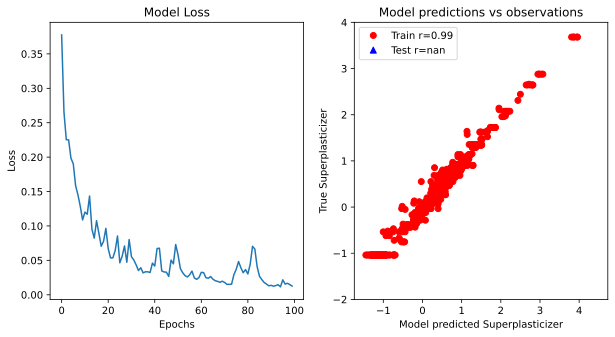

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(yHatTrain.detach().cpu(), train_labelsT,'ro')
ax[1].plot(yHatTest.detach().cpu(), test_labelsT, 'b^')
ax[1].legend()
ax[1].set_xlabel('Model predicted Superplasticizer')
ax[1].set_ylabel('True Superplasticizer')
ax[1].set_title(f'Model predictions vs observations')
ax[1].set_ylim([-2,4])

#correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().cpu().T, train_labelsT.T)[1,0]
corrTest = np.corrcoef(yHatTest.detach().cpu().T, test_labelsT.T)[1,0]
ax[1].legend([f'Train r={corrTrain:0.2f}', f'Test r={corrTest:0.3f}'])

plt.show()